In [4]:
# TAHAP 1: IMPOR DAN MUAT DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore') 
sns.set(style="whitegrid")

In [5]:
# 1.1. Muat data yang sudah diproses dari Tahap I
try:
    train_df = pd.read_csv('data_train_preprocessed.csv')
    test_df = pd.read_csv('data_test_preprocessed.csv')
except FileNotFoundError:
    print("Pastikan file 'data_train_preprocessed.csv' dan 'data_test_preprocessed.csv' ada di folder yang sama.")

print(f"Data latih dimuat dengan bentuk: {train_df.shape}")
print(f"Data uji dimuat dengan bentuk: {test_df.shape}")

Data latih dimuat dengan bentuk: (1792, 32)
Data uji dimuat dengan bentuk: (448, 32)


In [6]:
# BAGIAN A: TUGAS KLASIFIKASI (Target: Response)

print("Memulai Bagian A: Persiapan Data Klasifikasi")

# 1. Pisahkan X dan y untuk Klasifikasi
y_class_train = train_df['Response']
y_class_test = test_df['Response']
X_class_train = train_df.drop('Response', axis=1)
X_class_test = test_df.drop('Response', axis=1)
print(f"Bentuk X_class_train: {X_class_train.shape}")

Memulai Bagian A: Persiapan Data Klasifikasi
Bentuk X_class_train: (1792, 31)


In [7]:
# A.1: Skenario Seleksi Fitur (LASSO L1) untuk Klasifikasi

print("\nA.1: Menjalankan Seleksi Fitur LASSO (Klasifikasi)")

# Kita set C=0.05 (sedikit lebih kuat) untuk seleksi yang lebih ketat
l1_model_class = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', random_state=42)
l1_selector = SelectFromModel(l1_model_class, max_features=15)

l1_selector.fit(X_class_train, y_class_train)

# Ambil koefisien dari model yang sudah di-fit di DALAM selector
l1_coefs = l1_selector.estimator_.coef_[0]
l1_coefs_df = pd.DataFrame({
    'Feature': X_class_train.columns,
    'Importance (Abs Coef)': np.abs(l1_coefs)
}).sort_values(by='Importance (Abs Coef)', ascending=False)

# Ambil fitur yang lolos seleksi
selected_features_class = X_class_train.columns[l1_selector.get_support()]
print(f"LASSO memilih {len(selected_features_class)} fitur untuk Klasifikasi:")
print(list(selected_features_class))

# Buat dataframe baru
X_class_train_selected = X_class_train[selected_features_class]
X_class_test_selected = X_class_test[selected_features_class]

# Simpan hasil
X_class_train_selected.to_csv('X_class_train_selected.csv', index=False)
X_class_test_selected.to_csv('X_class_test_selected.csv', index=False)
print("Berhasil disimpan: 'X_class_train_selected.csv'")


A.1: Menjalankan Seleksi Fitur LASSO (Klasifikasi)
LASSO memilih 15 fitur untuk Klasifikasi:
['Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp1', 'Marital_Status_Married', 'Marital_Status_Together']
Berhasil disimpan: 'X_class_train_selected.csv'


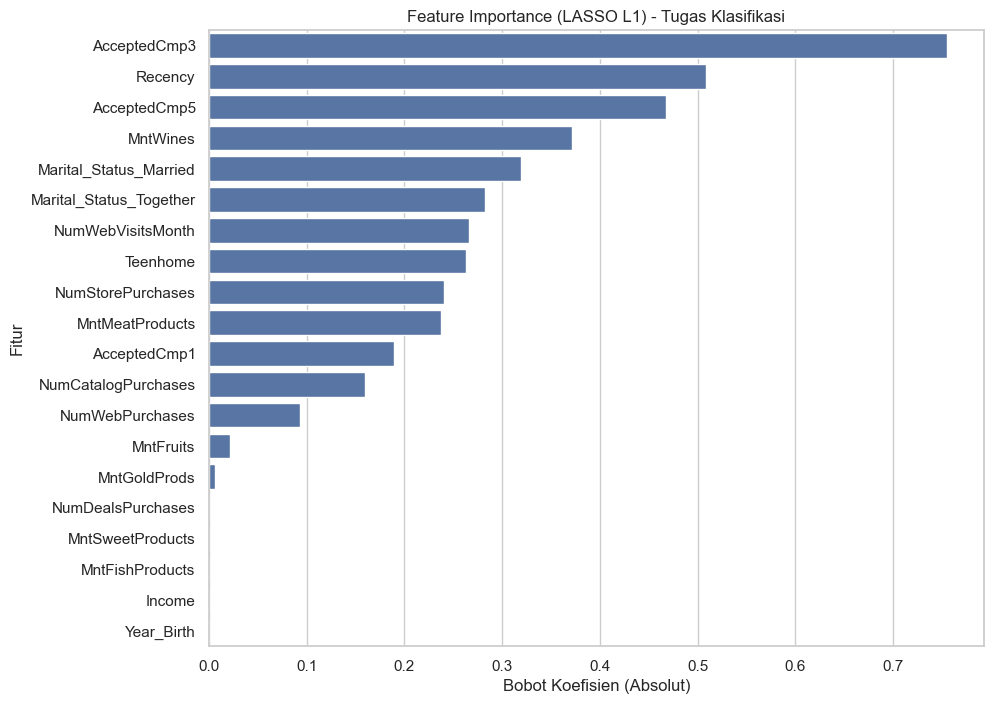

In [8]:
# --- [Plot A.1: Visualisasi Seleksi Fitur LASSO (Klasifikasi)] ---

plt.figure(figsize=(10, 8))
# Kita plot 20 fitur teratas untuk melihat mana yang dipilih dan mana yang tidak
sns.barplot(
    x='Importance (Abs Coef)', 
    y='Feature', 
    data=l1_coefs_df.head(20)
)
plt.title('Feature Importance (LASSO L1) - Tugas Klasifikasi')
plt.xlabel('Bobot Koefisien (Absolut)')
plt.ylabel('Fitur')
plt.show()

In [9]:
# A.2: Skenario Reduksi Dimensi (PCA) untuk Klasifikasi

print("\nA.2: Menjalankan PCA (Klasifikasi)")

# 1. Kita harus memisahkan data numerik dan biner SEBELUM menjalankan PCA
numerical_cols_class = [col for col in X_class_train.columns if X_class_train[col].nunique() > 2]
binary_cols_class = [col for col in X_class_train.columns if col not in numerical_cols_class]

X_train_num = X_class_train[numerical_cols_class]
X_train_bin = X_class_train[binary_cols_class]
X_test_num = X_class_test[numerical_cols_class]
X_test_bin = X_class_test[binary_cols_class]

# 2. Fit PCA untuk menangkap 95% varians
pca_class = PCA(n_components=0.95, random_state=42)
pca_class.fit(X_train_num) 
print(f"PCA memilih {pca_class.n_components_} komponen untuk Klasifikasi.")


A.2: Menjalankan PCA (Klasifikasi)
PCA memilih 13 komponen untuk Klasifikasi.


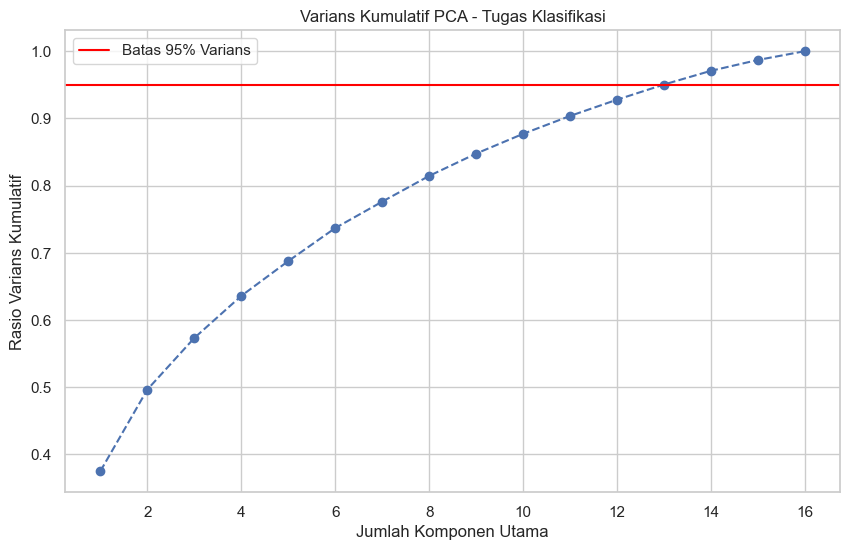

In [10]:
# --- [Plot A.2: Visualisasi Varians Kumulatif PCA (Klasifikasi)] ---

# Fit PCA penuh untuk memvisualisasikan varians
pca_full_class = PCA(random_state=42).fit(X_train_num)
cumulative_variance = np.cumsum(pca_full_class.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='red', linestyle='-', label='Batas 95% Varians')
plt.title('Varians Kumulatif PCA - Tugas Klasifikasi')
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Rasio Varians Kumulatif')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
# A.2 (Lanjutan): Transformasi dan Penyimpanan PCA Klasifikasi

# 3. Transformasi data numerik
X_train_pca_transformed = pca_class.transform(X_train_num)
X_test_pca_transformed = pca_class.transform(X_test_num)

# 4. Buat dataframe PCA dan gabungkan kembali
pc_cols = [f'PC{i+1}' for i in range(pca_class.n_components_)]
X_train_pca_df = pd.DataFrame(X_train_pca_transformed, columns=pc_cols)
X_test_pca_df = pd.DataFrame(X_test_pca_transformed, columns=pc_cols)

X_class_train_pca = pd.concat([X_train_bin.reset_index(drop=True), X_train_pca_df.reset_index(drop=True)], axis=1)
X_class_test_pca = pd.concat([X_test_bin.reset_index(drop=True), X_test_pca_df.reset_index(drop=True)], axis=1)

# 5. Simpan hasil
X_class_train_pca.to_csv('X_class_train_pca.csv', index=False)
X_class_test_pca.to_csv('X_class_test_pca.csv', index=False)
print("Berhasil disimpan: 'X_class_train_pca.csv'")

Berhasil disimpan: 'X_class_train_pca.csv'


In [12]:
# BAGIAN B: TUGAS REGRESI (Target: Income)

print("Memulai Bagian B: Persiapan Data Regresi")

y_reg_train = train_df['Income']
y_reg_test = test_df['Income']
X_reg_train = train_df.drop('Income', axis=1)
X_reg_test = test_df.drop('Income', axis=1)

print(f"Bentuk X_reg_train: {X_reg_train.shape}")

Memulai Bagian B: Persiapan Data Regresi
Bentuk X_reg_train: (1792, 31)


In [13]:
# B.1: Skenario Seleksi Fitur (LASSO) untuk Regresi

print("\nB.1: Menjalankan Seleksi Fitur LASSO (Regresi)")

l1_reg_model = Lasso(alpha=0.1, random_state=42) # alpha=0.1 adalah nilai default
l1_reg_selector = SelectFromModel(l1_reg_model, max_features=15)

l1_reg_selector.fit(X_reg_train, y_reg_train)

# Ambil koefisien dari model di dalam selector
l1_reg_coefs = l1_reg_selector.estimator_.coef_
l1_reg_coefs_df = pd.DataFrame({
    'Feature': X_reg_train.columns,
    'Importance (Abs Coef)': np.abs(l1_reg_coefs)
}).sort_values(by='Importance (Abs Coef)', ascending=False)

# Ambil fitur yang lolos seleksi
selected_features_reg = X_reg_train.columns[l1_reg_selector.get_support()]
print(f"LASSO memilih {len(selected_features_reg)} fitur untuk Regresi:")
print(list(selected_features_reg))

# Buat dataframe baru
X_reg_train_selected = X_reg_train[selected_features_reg]
X_reg_test_selected = X_reg_test[selected_features_reg]

# Simpan hasil
X_reg_train_selected.to_csv('X_reg_train_selected.csv', index=False)
X_reg_test_selected.to_csv('X_reg_test_selected.csv', index=False)
print("Berhasil disimpan: 'X_reg_train_selected.csv'")


B.1: Menjalankan Seleksi Fitur LASSO (Regresi)
LASSO memilih 7 fitur untuk Regresi:
['MntWines', 'MntMeatProducts', 'MntSweetProducts', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Berhasil disimpan: 'X_reg_train_selected.csv'


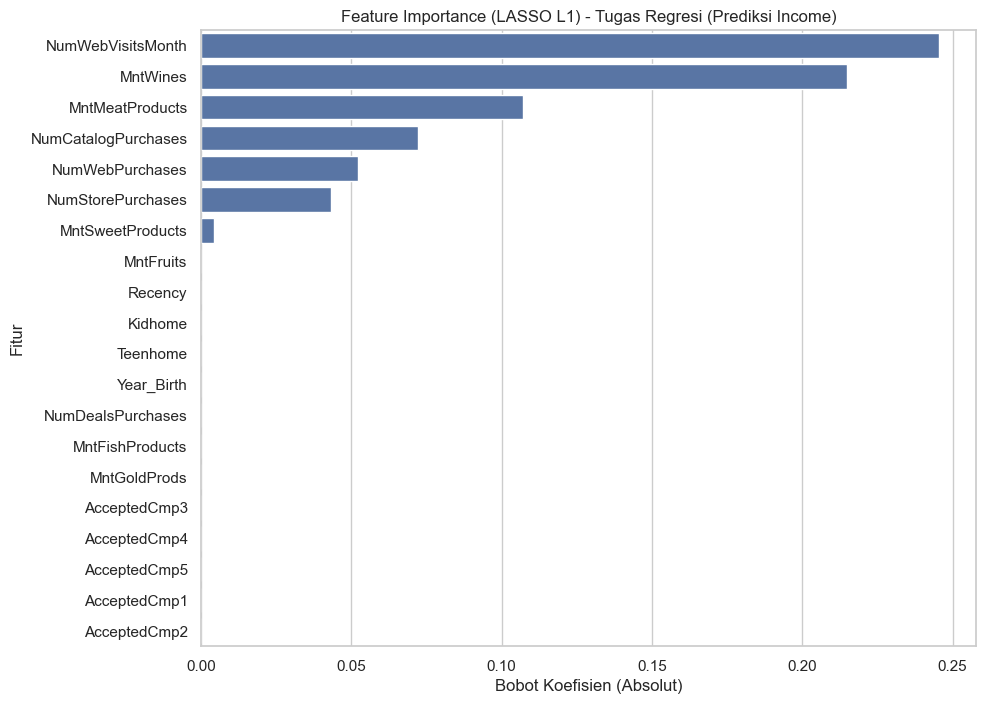

In [14]:
# --- [Plot B.1: Visualisasi Seleksi Fitur LASSO (Regresi)] ---

plt.figure(figsize=(10, 8))
# Plot 20 fitur teratas
sns.barplot(
    x='Importance (Abs Coef)', 
    y='Feature', 
    data=l1_reg_coefs_df.head(20)
)
plt.title('Feature Importance (LASSO L1) - Tugas Regresi (Prediksi Income)')
plt.xlabel('Bobot Koefisien (Absolut)')
plt.ylabel('Fitur')
plt.show()

In [15]:
# B.2: Skenario Reduksi Dimensi (PCA) untuk Regresi

print("B.2: Menjalankan PCA (Regresi)")

# 1. Tentukan kolom numerik (TANPA Income) dan biner (TERMASUK Response)
numerical_cols_reg = [col for col in X_reg_train.columns if X_reg_train[col].nunique() > 2]
binary_cols_reg = [col for col in X_reg_train.columns if col not in numerical_cols_reg]

# 2. Pisahkan data numerik dan biner
X_train_num_reg = X_reg_train[numerical_cols_reg]
X_train_bin_reg = X_reg_train[binary_cols_reg]
X_test_num_reg = X_reg_test[numerical_cols_reg]
X_test_bin_reg = X_reg_test[binary_cols_reg]

# 3. Fit PCA untuk menangkap 95% varians
pca_reg = PCA(n_components=0.95, random_state=42)
pca_reg.fit(X_train_num_reg)
print(f"PCA memilih {pca_reg.n_components_} komponen untuk Regresi.")

B.2: Menjalankan PCA (Regresi)
PCA memilih 13 komponen untuk Regresi.


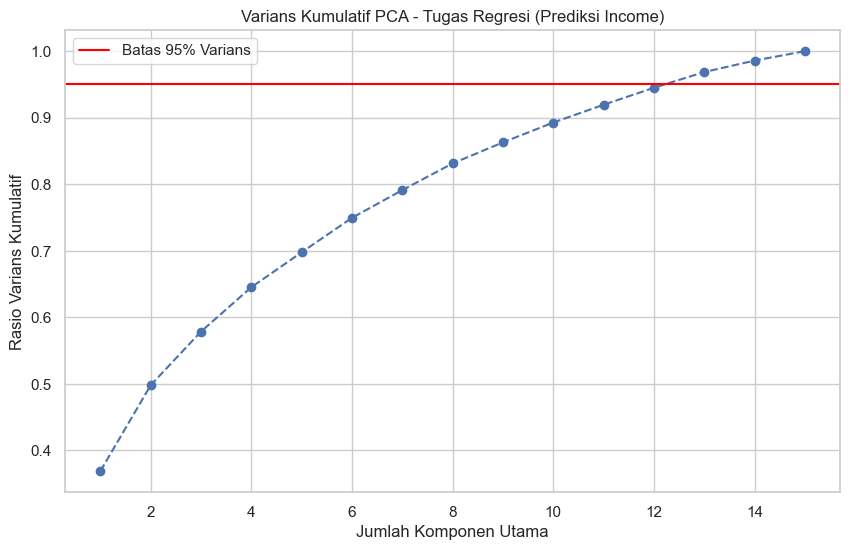

In [16]:
# --- [Plot B.2: Visualisasi Varians Kumulatif PCA (Regresi)] ---

# Fit PCA penuh untuk memvisualisasikan varians
pca_full_reg = PCA(random_state=42).fit(X_train_num_reg)
cumulative_variance_reg = np.cumsum(pca_full_reg.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_reg) + 1), cumulative_variance_reg, marker='o', linestyle='--')
plt.axhline(y=0.95, color='red', linestyle='-', label='Batas 95% Varians')
plt.title('Varians Kumulatif PCA - Tugas Regresi (Prediksi Income)')
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Rasio Varians Kumulatif')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [17]:
# B.2 (Lanjutan): Transformasi dan Penyimpanan PCA Regresi

# 4. Transformasi data numerik
X_train_pca_transformed_reg = pca_reg.transform(X_train_num_reg)
X_test_pca_transformed_reg = pca_reg.transform(X_test_num_reg)

# 5. Buat dataframe PCA dan gabungkan kembali
pc_cols_reg = [f'PC{i+1}' for i in range(pca_reg.n_components_)]
X_train_pca_df_reg = pd.DataFrame(X_train_pca_transformed_reg, columns=pc_cols_reg)
X_test_pca_df_reg = pd.DataFrame(X_test_pca_transformed_reg, columns=pc_cols_reg)

X_reg_train_pca = pd.concat([X_train_bin_reg.reset_index(drop=True), X_train_pca_df_reg.reset_index(drop=True)], axis=1)
X_reg_test_pca = pd.concat([X_test_bin_reg.reset_index(drop=True), X_test_pca_df_reg.reset_index(drop=True)], axis=1)

# 6. Simpan hasil
X_reg_train_pca.to_csv('X_reg_train_pca.csv', index=False)
X_reg_test_pca.to_csv('X_reg_test_pca.csv', index=False)
print("Berhasil disimpan: 'X_reg_train_pca.csv'")

Berhasil disimpan: 'X_reg_train_pca.csv'


In [18]:
# TAHAP 3: SIMPAN TARGET (y)

print("Menyimpan semua file target..")

y_class_train.to_csv('y_class_train.csv', index=False, header=True)
y_class_test.to_csv('y_class_test.csv', index=False, header=True)
y_reg_train.to_csv('y_reg_train.csv', index=False, header=True)
y_reg_test.to_csv('y_reg_test.csv', index=False, header=True)

print("\nPra-pemrosesan II Selesai.")
print("Total 12 file (8 fitur, 4 target) telah disimpan.")

Menyimpan semua file target..

Pra-pemrosesan II Selesai.
Total 12 file (8 fitur, 4 target) telah disimpan.
